<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_Computer_Vision/blob/main/NASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Mount and Packages/Modules Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cuda'

# **※ Dataset Preparation**

###**CIFAR-10 Dataset** -- *32 X 32 pixels RGB Color images* with 10 class labels  
0(비행기), 1(자동차), 2(새), 3(고양이), 4(사슴), 5(개), 6(개구리), 7(말), 8(배), 9(트럭)

Files already downloaded and verified
Files already downloaded and verified
Train Data Length : 50000
# of Class Labels : [0 1 2 3 4 5 6 7 8 9]


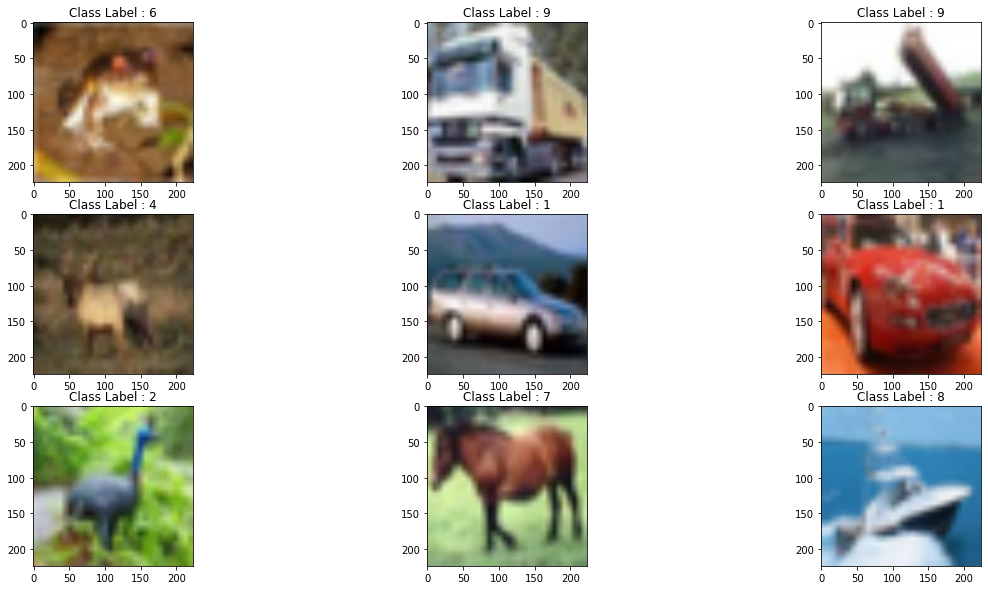

In [2]:
## Define Dataset Root Path and Transforms
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")

apply_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


## Get CIFAR-10 Image Dataset
train_data = torchvision.datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=apply_transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=apply_transform
)


## Define Image Plot function
def sample_img_show(data, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    for i in range(9):
        image = data[i][0]
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class Label : {data[i][1]}")
    fig.show()


## Check CIFAR-10 Dataset
print(f"Train Data Length : {len(train_data.targets)}")
print(f"# of Class Labels : {np.unique(train_data.targets)}")
sample_img_show(data=train_data)

###**Training / Validation Dataset Split**

In [3]:
## Training / Validation Dataset Split with random_split
random_seed = 0
torch.manual_seed(random_seed)

valid_size = int(len(train_data) * 0.2)
train_size = len(train_data) - valid_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

print(f"Training Dataset : {len(train_data)}")
print(f"Validation Dataset : {len(valid_data)}")
print()

print(train_data[0][0].shape)

Training Dataset : 40000
Validation Dataset : 10000

torch.Size([3, 224, 224])


###**Definition of DataLoader Class**

In [4]:
## Definition of DataLoader Class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=50, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=False, drop_last=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader
loaders["test"] = test_loader

print(f"Train Loader Length = {len(train_loader)},  Valid Loader Length = {len(valid_loader)},  Test Loader Length = {len(test_loader)}")

Train Loader Length = 800,  Valid Loader Length = 200,  Test Loader Length = 200


# <font color="#FF0000"> **※ NASNet Model and Actuator Definition** </font>

### <font color="#FF0000"> **① Architecture of NASNet-A Model with Normal/Reduction Conv-Cell Generation** </font>

In [5]:
## NASNet-A Model with Normal/Reduction Conv-Cell Generation for ImageNet dataset Architecture and N=1
class NASNet(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()                                                                                                      # Input Image Tensor = 3 X 224 X 224
        
        self.nasnet_conv = nn.Sequential(                                                                                       # ① 1st Vanilla Conv Block = 32 X 112 X 112
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            swish()
        )

        self.reduction_cell_1 = reduction_cell(after_channels=32, before_channels=3, mid_channels=16, out_channels=16)          # ② 2nd Reduction Cell = 72 X 28 X 28
        self.reduction_cell_2 = reduction_cell(after_channels=48, before_channels=32, mid_channels=24, out_channels=24)

        self.normal_cell_1 = normal_cell(after_channels=72, before_channels=48, out_channels=36)                                # ③ 3rd Normal & Reduction Cell = 270 X 14 X 14
        self.reduction_cell_3 = reduction_cell(after_channels=180, before_channels=72, mid_channels=90, out_channels=90)

        self.normal_cell_2 = normal_cell(after_channels=270, before_channels=180, out_channels=90)                              # ④ 4th Normal & Reduction Cell = 900 X 7 X 7
        self.reduction_cell_4 = reduction_cell(after_channels=450, before_channels=270, mid_channels=300, out_channels=300)

        self.normal_cell_3 = normal_cell(after_channels=900, before_channels=450, out_channels=400)                             # ⑤ 5th Normal Cell = 2000 X 7 X 7

        self.nasnet_fc = nn.Sequential(                                                                                         # ⑤ 6th Advanced Fully-Connected Block = 10 Vectorize
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),

            nn.Linear(in_features=2000, out_features=512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.25),
            swish(),

            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.25),
            swish(),

            nn.Linear(in_features=128, out_features=n_class)
        )

    def forward(self, input):
        temp = self.nasnet_conv(input)

        temp1 = self.reduction_cell_1(temp, input)
        temp2 = self.reduction_cell_2(temp1, temp)

        temp3 = self.normal_cell_1(temp2, temp1)
        temp4 = self.reduction_cell_3(temp3, temp2)

        temp5 = self.normal_cell_2(temp4, temp3)
        temp6 = self.reduction_cell_4(temp5, temp4)

        temp7 = self.normal_cell_3(temp6, temp5)

        output = self.nasnet_fc(temp7)

        return output


## Normal Convolutional Cell Generation in NASNet-A Model
class normal_cell(nn.Module):
    def __init__(self, after_channels, before_channels, out_channels):
        super().__init__()

        self.adjust_block = adjust_block(channels=before_channels)
        self.convert1 = nn.Sequential(
            nn.Conv2d(in_channels=after_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            swish()
        )
        self.convert2 = nn.Sequential(
            nn.Conv2d(in_channels=before_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            swish()
        )

        self.after_ds_conv3 = ds_conv(in_channels=after_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)         # Hstate DS-Conv with size=3
        self.before_ds_conv3 = ds_conv(in_channels=before_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)       # H-1state DS-Conv with size=3

        self.after_ds_conv5 = ds_conv(in_channels=after_channels, out_channels=out_channels, kernel_size=5, stride=1, padding=2)         # Hstate DS-Conv with size=5
        self.before_ds_conv5 = ds_conv(in_channels=before_channels, out_channels=out_channels, kernel_size=5, stride=1, padding=2)       # H-1state DS-Conv with size=5

        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)

    def forward(self, after_input, before_input):
        if after_input.size()[2] != before_input.size()[2] and after_input.size()[3] != before_input.size()[3]:
            before_input = self.adjust_block(before_input)

        a_block = self.after_ds_conv3(after_input) + self.convert1(after_input)                                 # ① A Block in Normal Cell : After DS-Conv3 & After Identity Mapping
        b_block = self.before_ds_conv3(before_input) + self.after_ds_conv5(after_input)                         # ② B Block in Normal Cell : Before DS-Conv3 & After DS-Conv5
        c_block = self.avg_pool(self.convert1(after_input)) + self.convert2(before_input)                       # ③ C Block in Normal Cell : After AvgPool & Before Identity Mapping
        d_block = self.avg_pool(self.convert2(before_input)) + self.avg_pool(self.convert2(before_input))       # ④ D Block in Normal Cell : Before AvgPool & Before AvgPool
        e_block = self.before_ds_conv5(before_input) + self.before_ds_conv3(before_input)                       # ⑤ E Block in Normal Cell : Before DS-Conv5 & Before DS-Conv3

        output = torch.cat([a_block, b_block, c_block, d_block, e_block], dim=1)                                # Concatenation with Channel Dimension

        return output


## Reduction Convolutional Cell Generation in NASNet-A Model
class reduction_cell(nn.Module):
    def __init__(self, after_channels, before_channels, mid_channels, out_channels):
        super().__init__()

        self.adjust_block = adjust_block(channels=before_channels)
        self.convert1 = nn.Sequential(
            nn.Conv2d(in_channels=after_channels, out_channels=mid_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(mid_channels),
            swish()
        )
        self.convert2 = nn.Sequential(
            nn.Conv2d(in_channels=after_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            swish()
        )
        self.convert3 = nn.Sequential(
            nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            swish()
        )

        self.ds_conv7 = ds_conv(in_channels=before_channels, out_channels=mid_channels, kernel_size=7, stride=2, padding=3)             # H-1state DS-Conv with size=7
        self.after_ds_conv5 = ds_conv(in_channels=after_channels, out_channels=mid_channels, kernel_size=5, stride=2, padding=2)        # Hstate DS-Conv with size=5
        self.before_ds_conv5 = ds_conv(in_channels=before_channels, out_channels=out_channels, kernel_size=5, stride=2, padding=2)      # H-1state DS-Conv with size=5
        
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.ds_conv3 = ds_conv(in_channels=mid_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)                # Process in Current Block DS-Conv with size=3

        self.avg_pool_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.avg_pool_2 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, after_input, before_input):
        if after_input.size()[2] != before_input.size()[2] and after_input.size()[3] != before_input.size()[3]:
            before_input = self.adjust_block(before_input)

        a_block = self.ds_conv7(before_input) + self.after_ds_conv5(after_input)                        # ① A Block in Reduction Cell : Before DS-Conv7 & After DS-Conv5
        b_block = self.max_pool(self.convert1(after_input)) + self.ds_conv7(before_input)               # ② B Block in Reduction Cell : After MaxPool & Before DS-Conv7
        c_block = self.avg_pool_2(self.convert2(after_input)) + self.before_ds_conv5(before_input)      # ③ C Block in Reduction Cell : After AvgPool & Before DS-Conv5

        d_block = self.max_pool(self.convert2(after_input)) + self.ds_conv3(a_block)                    # ④ D Block in Reduction Cell : After MaxPool & Identity Mapping with A Block
        e_block = self.avg_pool_1(self.convert3(a_block)) + b_block                                     # ⑤ E Block in Reduction Cell : AvgPool with A Block & Identity Mapping with B Block

        output = torch.cat([c_block, d_block, e_block], dim=1)                          # Concatenation with Channel Dimension

        return output


## Depth-wise Separable Convolution in NASNet-A Model
class ds_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.depthwise = nn.Sequential(                                                                     # ① Depth-wise Convolution in DS-Conv with Swish
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            swish()
        )

        self.pointwise = nn.Sequential(                                                                     # ② Point-wise Convolution in DS-Conv with Swish
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            swish()
        )
    
    def forward(self, input):
        temp = self.depthwise(input)
        output = self.pointwise(temp)

        return output


## Adjustment of Feature Map Size by 2 Division for Addition Operation in NASNet-A Cells
class adjust_block(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.adjust_block = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(channels),
            swish()
        )
    
    def forward(self, input):
        output = self.adjust_block(input)

        return output


## Automated Activation Function : Swish
class swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        output = input * self.sigmoid(input)

        return output


nasnet_sample = NASNet(n_class=10).to(device)           # NASNet Model for Sample Version
summary(nasnet_sample, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
           Sigmoid-3         [-1, 32, 112, 112]               0
             swish-4         [-1, 32, 112, 112]               0
            Conv2d-5          [-1, 3, 112, 112]              84
       BatchNorm2d-6          [-1, 3, 112, 112]               6
           Sigmoid-7          [-1, 3, 112, 112]               0
             swish-8          [-1, 3, 112, 112]               0
      adjust_block-9          [-1, 3, 112, 112]               0
           Conv2d-10            [-1, 3, 56, 56]             150
      BatchNorm2d-11            [-1, 3, 56, 56]               6
          Sigmoid-12            [-1, 3, 56, 56]               0
            swish-13            [-1, 3, 56, 56]               0
           Conv2d-14           [-1, 16,

### <font color="#FF0000"> **② Actuator(Trainer/Tester) Construction for NASNet** </font>

In [6]:
## NASNet-A Actuator Definition
class NASNet_Actuator(nn.Module):
    def __init__(self, model, loaders, opt="sgd", lr=0.01, has_scheduler=False, device="cuda"):
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()

        self.train_loader = loaders["train"]
        self.valid_loader = loaders["valid"]
        self.test_loader = loaders["test"]

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
    
    def _get_optimizer(self, opt="sgd", lr=0.01):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=10, gamma=0.3, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)   # 학습 도중 lr_lambda에 정의한 function에 의해 learning rate을 순차적으로 줄임
    
    def train_and_valid(self, max_epochs=10, disp_epochs=1):
        print("========== Train and Valid Start ==========")
        start_time = time.time()

        history = {"Train_Loss" : [], "Train_Acc" : [], "Valid_Loss" : [], "Valid_Acc" : []}

        for epoch in tqdm(range(max_epochs), desc="Training Process..."):
            train_loss, train_acc = self._train_epoch()
            valid_loss, valid_acc = self._valid_epoch()

            history["Train_Loss"].append(train_loss)
            history["Train_Acc"].append(train_acc)
            history["Valid_Loss"].append(valid_loss)
            history["Valid_Acc"].append(valid_acc)

            if self.has_scheduler:
                self.scheduler.step()
            
            if epoch % disp_epochs == 0:
                print(f"{epoch+1}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}, Time : {time.time() - start_time:>3f}")
                start_time = time.time()
        
        self.plot_history(history)
    
    def _train_epoch(self):
        train_epoch_loss, train_epoch_acc = 0, 0
        self.model.train()

        for (a, b) in self.train_loader:
            a = a.to(device=self.device)
            b = b.to(device=self.device)

            b_hat = self.model(a)
            loss = self.loss(b_hat, b)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_epoch_loss += loss.to("cpu").item()
            train_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        train_epoch_loss /= len(self.train_loader)
        train_epoch_acc /= len(self.train_loader)

        return train_epoch_loss, train_epoch_acc
    
    def _valid_epoch(self):
        valid_epoch_loss, valid_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.valid_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                valid_epoch_loss += loss.to("cpu").item()
                valid_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        valid_epoch_loss /= len(self.valid_loader)
        valid_epoch_acc /= len(self.valid_loader)

        return valid_epoch_loss, valid_epoch_acc
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["Train_Loss"], color="red", label="Train Loss")
        ax.plot(history["Valid_Loss"], color="orange", label="Valid Loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["Train_Acc"], color="red", label="Train Accuracy")
        ax.plot(history["Valid_Acc"], color="orange", label="Valid Accuracy")
        ax.set_title("Accuracy")
        ax.legend()

        fig.show()
    
    def test(self):
        print("========== Test Start ==========")
        start_time = time.time()

        test_epoch_loss, test_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.test_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                test_epoch_loss += loss.to("cpu").item()
                test_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        test_epoch_loss /= len(self.test_loader)
        test_epoch_acc /= len(self.test_loader)

        print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}, Test time : {time.time() - start_time:>3f}")

# <font color="#FFBB00"> **※ Training / Validating / Testing** </font>

========== Train and Valid Start ==========


Training Process...:  10%|█         | 1/10 [05:10<46:34, 310.51s/it]

1/10 Epoch ==> Train Loss : 1.215648, Train Acc : 0.559875, Valid Loss : 0.835190, Valid Acc : 0.705300, Time : 310.508489


Training Process...:  20%|██        | 2/10 [10:20<41:20, 310.11s/it]

2/10 Epoch ==> Train Loss : 0.674878, Train Acc : 0.766750, Valid Loss : 0.642860, Valid Acc : 0.772800, Time : 309.840839


Training Process...:  30%|███       | 3/10 [15:30<36:11, 310.15s/it]

3/10 Epoch ==> Train Loss : 0.461375, Train Acc : 0.843075, Valid Loss : 0.532667, Valid Acc : 0.817700, Time : 310.185728


Training Process...:  40%|████      | 4/10 [20:40<31:00, 310.11s/it]

4/10 Epoch ==> Train Loss : 0.319093, Train Acc : 0.892475, Valid Loss : 0.589694, Valid Acc : 0.804700, Time : 310.045453


Training Process...:  50%|█████     | 5/10 [25:50<25:51, 310.22s/it]

5/10 Epoch ==> Train Loss : 0.219048, Train Acc : 0.926875, Valid Loss : 0.515427, Valid Acc : 0.831200, Time : 310.407413


Training Process...:  60%|██████    | 6/10 [31:01<20:40, 310.22s/it]

6/10 Epoch ==> Train Loss : 0.153708, Train Acc : 0.948850, Valid Loss : 0.632807, Valid Acc : 0.816300, Time : 310.225870


Training Process...:  70%|███████   | 7/10 [36:11<15:30, 310.28s/it]

7/10 Epoch ==> Train Loss : 0.120974, Train Acc : 0.958625, Valid Loss : 0.590345, Valid Acc : 0.826400, Time : 310.414647


Training Process...:  80%|████████  | 8/10 [41:21<10:20, 310.25s/it]

8/10 Epoch ==> Train Loss : 0.089043, Train Acc : 0.970200, Valid Loss : 0.644340, Valid Acc : 0.822900, Time : 310.165290


Training Process...:  90%|█████████ | 9/10 [46:32<05:10, 310.32s/it]

9/10 Epoch ==> Train Loss : 0.088985, Train Acc : 0.969175, Valid Loss : 0.630473, Valid Acc : 0.832500, Time : 310.473651


Training Process...: 100%|██████████| 10/10 [51:42<00:00, 310.24s/it]

10/10 Epoch ==> Train Loss : 0.074079, Train Acc : 0.975250, Valid Loss : 0.630491, Valid Acc : 0.829400, Time : 310.159312
Total Training Time : 3102.457103
========== Test Start ==========


Test loss: 0.650284, Test acc: 0.832700, Test time : 23.454672


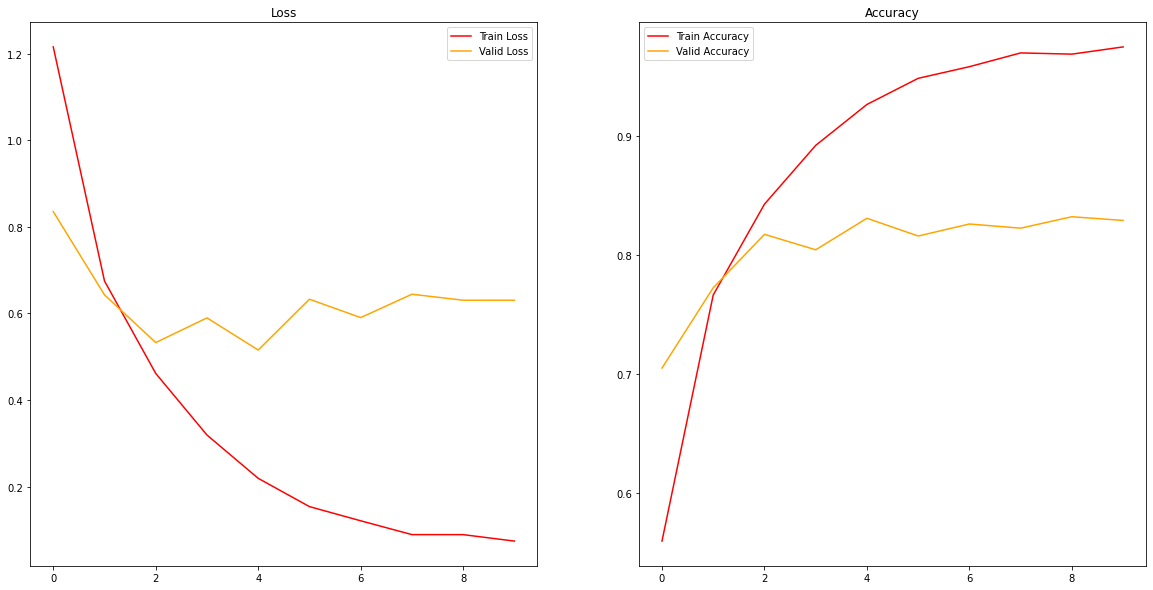

In [9]:
## Training and Validating and Testing for CIFAR-10 by NASNet-A
device = "cuda"
nasnet_model = NASNet(n_class=10).to(device)                            # NASNet-A Model for Training Version
nasnet_actuator = NASNet_Actuator(model=nasnet_model, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)

start_time = time.time()
nasnet_actuator.train_and_valid(max_epochs=10, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

nasnet_actuator.test()                                                  # NASNet-A Model for Testing Version

# <font color="#2F9D27"> **※ NASNet Model Save and Load** </font>

### <font color="#2F9D27"> **① NASNet Model Save based on Train/Valid History** </font>

In [10]:
## NASNet-A Model Save
for param_tensor in nasnet_model.state_dict():
    print(f"{param_tensor} : \t {nasnet_model.state_dict()[param_tensor].size()}")   # NASNet-A model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(nasnet_model.state_dict(), os.path.join(model_dir, "NASNet-A.pth"))

nasnet_conv.0.weight : 	 torch.Size([32, 3, 3, 3])
nasnet_conv.0.bias : 	 torch.Size([32])
nasnet_conv.1.weight : 	 torch.Size([32])
nasnet_conv.1.bias : 	 torch.Size([32])
nasnet_conv.1.running_mean : 	 torch.Size([32])
nasnet_conv.1.running_var : 	 torch.Size([32])
nasnet_conv.1.num_batches_tracked : 	 torch.Size([])
reduction_cell_1.adjust_block.adjust_block.0.weight : 	 torch.Size([3, 3, 3, 3])
reduction_cell_1.adjust_block.adjust_block.0.bias : 	 torch.Size([3])
reduction_cell_1.adjust_block.adjust_block.1.weight : 	 torch.Size([3])
reduction_cell_1.adjust_block.adjust_block.1.bias : 	 torch.Size([3])
reduction_cell_1.adjust_block.adjust_block.1.running_mean : 	 torch.Size([3])
reduction_cell_1.adjust_block.adjust_block.1.running_var : 	 torch.Size([3])
reduction_cell_1.adjust_block.adjust_block.1.num_batches_tracked : 	 torch.Size([])
reduction_cell_1.convert1.0.weight : 	 torch.Size([16, 32, 1, 1])
reduction_cell_1.convert1.0.bias : 	 torch.Size([16])
reduction_cell_1.convert1.1

### <font color="#2F9D27"> **② NASNet Model Load and Performance Estimation** </font>

In [11]:
## NASNet-A Model Load
device = "cuda"

print("========== NASNet-A Test without Load ==========")    # ① 먼저 학습하지 않은 상태로 Actuator를 통해 Test dataset 성능 측정
nasnet = NASNet(n_class=10).to(device)
nasnet_actuator = NASNet_Actuator(model=nasnet, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
nasnet_actuator.test()

model_path = os.path.join(model_dir, "NASNet-A.pth")
print(model_path)
print()

print("========== NASNet-A Test with Load ==========")       # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
nasnet.load_state_dict(torch.load(model_path))
nasnet.eval()

nasnet_loaded_actuator = NASNet_Actuator(model=nasnet, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
nasnet_loaded_actuator.test()

========== NASNet-A Test without Load ==========
========== Test Start ==========
Test loss: 2.303753, Test acc: 0.100000, Test time : 24.411066
/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/model/NASNet-A.pth

========== NASNet-A Test with Load ==========
========== Test Start ==========
Test loss: 0.650284, Test acc: 0.832700, Test time : 23.866916
